In [1]:
%load_ext autoreload

In [27]:
%autoreload 2
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from multiproc_VAR_p_grid_search import predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

In [19]:
session = 'Mary-Anesthesia-20160809-01'

# Load Neural Data

In [20]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [21]:
variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['unitInfo']

# Load Results

In [9]:
results_dir = '/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR_p/Mary-Anesthesia-20160809-01_num_window_samples_5_Jun-30-2022_0140'
result_threshes = [float(f.split('_')[-1]) for f in os.listdir(results_dir) if f.startswith('results')]
thresh_rule = 'max' # or min
if thresh_rule == 'max':
    thresh = np.max(result_threshes)
else: #thresh_rule == 'min'
    thresh = np.min(result_threshes)
result_folder_name = f"results_thresh_{thresh}"

VAR_p_results = {}
for area in tqdm(os.listdir(os.path.join(results_dir, result_folder_name))):
    VAR_p_results[area] = load(os.path.join(results_dir, result_folder_name, area))

  0%|          | 0/5 [00:00<?, ?it/s]

# Plot

In [36]:
area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

area_labels = {'vlPFC': 'PFC', 'FEF': '8A', '7b': 'PPC', 'CPB': 'STG', 'all': 'all'}

In [37]:
 anesthesia_start = session_info['drugStart'][0]

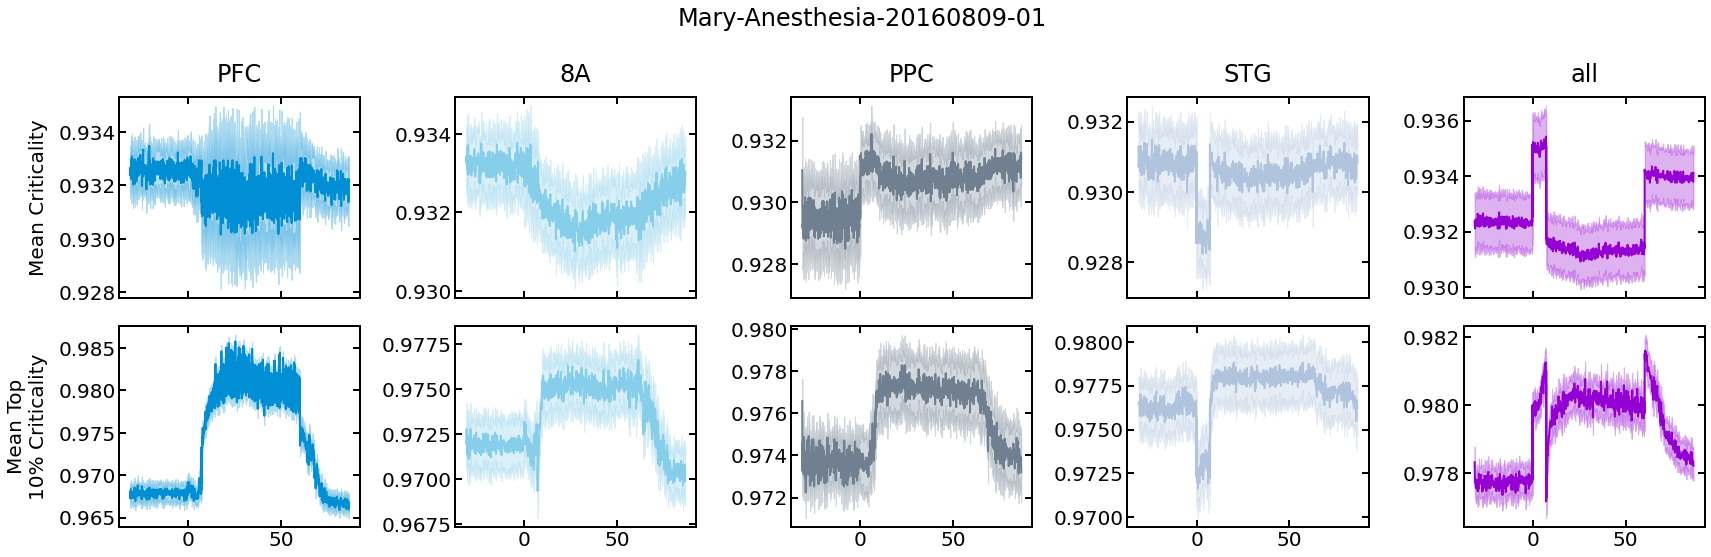

In [51]:
top_pct = 10
end_ind = -1
fig, axs = plt.subplots(2, 5, figsize=(24, 8), sharex=True)
for i, area in enumerate(area_colors.keys()):
    df = VAR_p_results[area][:end_ind]
    mean_crit = df.criticality_inds.apply(lambda x: x.mean())
    mean_crit_se = df.criticality_inds.apply(lambda x: x.std()/np.sqrt(len(x)))
    axs[0][i].plot((df.start_time - anesthesia_start)/60, mean_crit, c=area_colors[area])
    axs[0][i].fill_between((df.start_time - anesthesia_start)/60, mean_crit - mean_crit_se, mean_crit + mean_crit_se, color=area_colors[area], alpha=0.3)
    
    axs[0][i].set_title(area_labels[area])
    mean_crit_top_pct = df.criticality_inds.apply(lambda x: x[x > np.percentile(x, 100 - top_pct)].mean())
    mean_crit_top_pct_se = df.criticality_inds.apply(lambda x: x[x > np.percentile(x, 100 - top_pct)].std()/np.sqrt(len(x[x > np.percentile(x, 100 - top_pct)])))
    axs[1][i].plot((df.start_time - anesthesia_start)/60, mean_crit_top_pct, c=area_colors[area])
    axs[1][i].fill_between((df.start_time - anesthesia_start)/60, mean_crit_top_pct - mean_crit_top_pct_se, mean_crit_top_pct + mean_crit_top_pct_se, color=area_colors[area], alpha=0.3)
    if i == 0:
        axs[0][i].set_ylabel('Mean Criticality')
        axs[1][i].set_ylabel(f'Mean Top\n{top_pct}% Criticality')
fig.suptitle(session)
plt.tight_layout()
plt.show()